# Explanation of topic

### Etherium Prediction

In this model, we are taking a Kaggle dataset for Etherium's value from 2016-05-09 to 2020-04-15. Using this, we will train a model to predict the next day's close after a set number of time_steps(Ended up with 130 as the most useful in this project) We will need to flip the dataset and prepare it by removing unneeded data, but otherwise the data is very clean.

In [1]:
#Loading all imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner as kt
import os
import shutil

Using TensorFlow backend


In [2]:
df = pd.read_csv("Etherium1day.csv")

# Data Analysis

In [3]:
#Important note is that the dataframe is ordered newest to oldest. Must be flipped for easier time-series analysis
df.head()

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
1,2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44
2,2020-04-13,ETHUSD,158.56,159.51,150.12,156.97,15698.32,2416728.28
3,2020-04-12,ETHUSD,158.66,165.37,155.21,158.56,12877.33,2082804.05
4,2020-04-11,ETHUSD,158.26,161.49,154.25,158.66,13761.72,2172914.57


In [4]:
df.describe()

,Open,High,Low,Close,Volume ETH,Volume USD
count,1438.000000,1438.000000,1438.000000,1438.000000,1.438000e+03,1.438000e+03
mean,239.397149,248.919200,227.681446,239.468011,3.720638e+04,1.139557e+07
std,237.662224,248.677428,222.794938,237.606382,6.908336e+04,2.143780e+07
min,6.770000,7.290000,5.990000,6.770000,0.000000e+00,0.000000e+00
25%,79.782500,84.875000,74.677500,80.732500,7.020215e+03,7.541171e+05
50%,181.430000,187.020000,175.850000,181.430000,1.780439e+04,3.221372e+06
75%,297.735000,306.015000,287.427500,297.502500,4.204451e+04,1.204918e+07
max,1381.850000,1420.010000,1270.000000,1381.850000,1.827755e+06,2.221193e+08


In [5]:
#No null values present
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1438 non-null   object 
 1   Symbol      1438 non-null   object 
 2   Open        1438 non-null   float64
 3   High        1438 non-null   float64
 4   Low         1438 non-null   float64
 5   Close       1438 non-null   float64
 6   Volume ETH  1438 non-null   float64
 7   Volume USD  1438 non-null   float64
dtypes: float64(6), object(2)
memory usage: 90.0+ KB


In [6]:
#Switching to Pandas version of datetime for easier visualization
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

<function matplotlib.pyplot.show(close=None, block=None)>

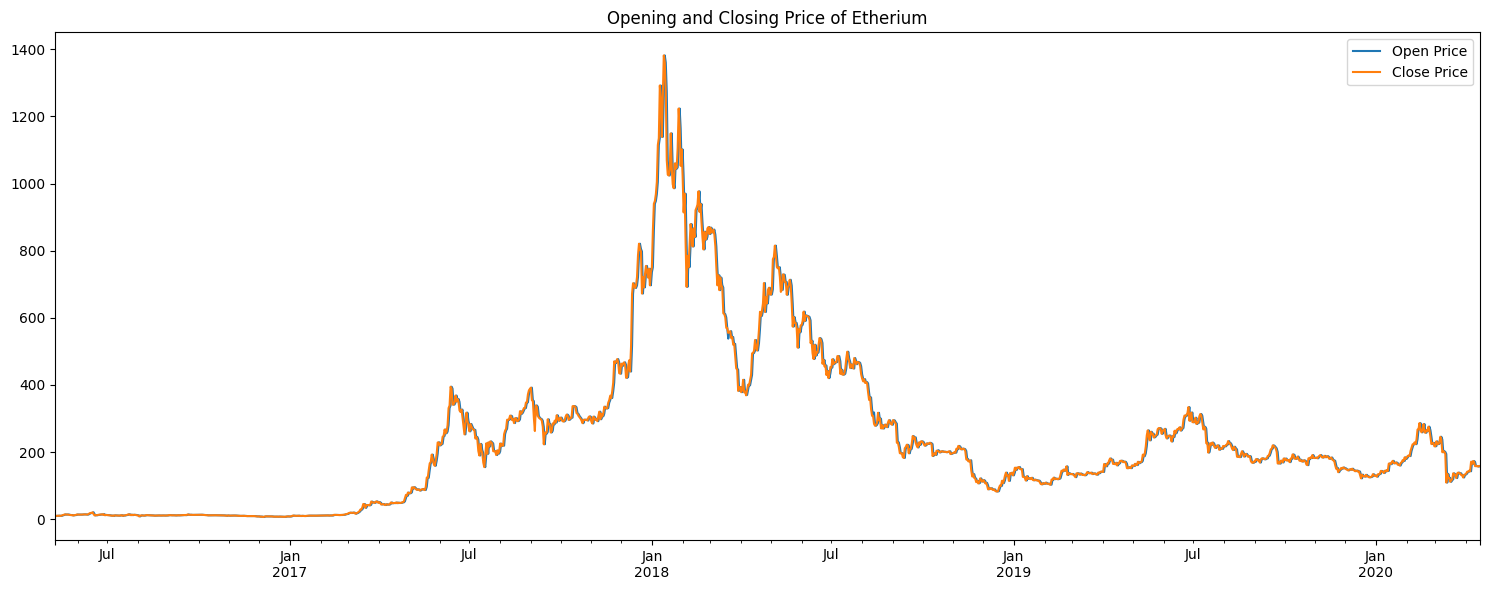

In [7]:
plt.figure(figsize =(15,6))
df[r'Open'].plot()
df[r'Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title('Opening and Closing Price of Etherium')
plt.legend(['Open Price','Close Price'])
plt.tight_layout()
plt.show

# Data preparation

In [8]:
#Variable declaration
n_cols = 1
time_steps=30
#We only need the closing values, and we must remember to flip the dataset to make it more intuitive to work with.
dataset = df[r'Close'][::-1]
dataset = pd.DataFrame(dataset)
data = dataset.values
data.shape

(1438, 1)

In [9]:
#I used standard scaling, but an interesting note is that normalization changes the predicted values to a 
#bit less than actual values, where as standard scaling leads to them a bit higher. I left both here
#So you can test the change.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.array(data))

In [10]:
#Preparing to split data. Have to make it a bit more specific with overlap so there is no gap in prediction dates between train
#and test data
train_size = int((len(data)*0.80))
test_size = len(data)-train_size+time_steps
print('Train size: ',train_size, 'Test size: ',test_size)

Train size:  1150 Test size:  318


In [11]:
train_data = scaled_data[0:train_size,:]
print(train_data.shape)
test_data = scaled_data[train_size-time_steps:,:]
print(test_data.shape)

(1150, 1)
(318, 1)


In [12]:
#Creating the dataset of arrays needed to work with time-series.
X_train = []
y_train = []
n_cols = 1

for i in range(time_steps, len(train_data)):
    X_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])
    if i <=time_steps:
        print('X_train: ', X_train)
        print('y_train: ', y_train)

X_train:  [array([[-0.96616869],
       [-0.96743172],
       [-0.96427414],
       [-0.96524247],
       [-0.96317952],
       [-0.96503196],
       [-0.96583188],
       [-0.96031665],
       [-0.95669595],
       [-0.95219114],
       [-0.94713902],
       [-0.94966508],
       [-0.94937037],
       [-0.94840205],
       [-0.95113862],
       [-0.95421199],
       [-0.95543292],
       [-0.95513822],
       [-0.96023244],
       [-0.9584642 ],
       [-0.95543292],
       [-0.95488561],
       [-0.94848625],
       [-0.94945457],
       [-0.94966508],
       [-0.94915987],
       [-0.94983348],
       [-0.94962298],
       [-0.94857045],
       [-0.94713902]])]
y_train:  [array([-0.94709691])]


In [13]:
#Same as above, but for test data
X_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    X_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_cols))
X_test.shape

(288, 30, 1)

In [14]:
#Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
#Convert to 3 dimensions
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_cols))

In [16]:
X_train.shape, y_train.shape

((1120, 30, 1), (1120, 1))

In [17]:
X_test.shape, y_test.shape

((288, 30, 1), (288, 1))

# Model building

In [18]:
def model_builder(hp):
    #Create model
    model = Sequential()
    
    #Look for best number of neurons between 4-32
    hp_units = hp.Int('units', min_value=15, max_value=150, step=15)
    model.add(Dense(units=hp_units, input_dim=X_train.shape[1], activation='relu'))
    
    #Add dropout to prevent overfitting
    model.add(Dropout(0.15))
    
    #Add the final layer
    model.add(Dense(1, activation='linear'))
    
    #Compile model
    model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])
    return model

In [19]:
#Deleting previous logs to run tuner
folder_path = "my_dir/etherium_predict/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir/etherium_predict/' has been deleted.


In [20]:
#Set and save tuner to help us find best number of neurons
tuner = kt.Hyperband(model_builder, objective='val_mean_absolute_error',
                     max_epochs=10, factor=3, 
                     directory='my_dir',
                     project_name='etherium_predict')

In [21]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams) 
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, accuracy, step=1)

In [22]:
#Create EarlyStopping to enhance efficiency
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.
""")

Trial 10 Complete [00h 00m 01s]
val_mean_absolute_error: 0.11017890274524689

Best val_mean_absolute_error So Far: 0.07387929409742355
Total elapsed time: 00h 00m 08s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 150.



In [24]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs to find best epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

val_mae_per_epoch = history.history['val_mean_absolute_error']
best_epoch = val_mae_per_epoch.index(min(val_mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
28/28 [==============================] - 0s 5ms/step - loss: 0.4223 - mean_absolute_error: 0.4223 - val_loss: 0.0847 - val_mean_absolute_error: 0.0847
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2487 - mean_absolute_error: 0.2487 - val_loss: 0.0762 - val_mean_absolute_error: 0.0762
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2151 - mean_absolute_error: 0.2151 - val_loss: 0.0675 - val_mean_absolute_error: 0.0675
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1831 - mean_absolute_error: 0.1831 - val_loss: 0.0642 - val_mean_absolute_error: 0.0642
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1721 - mean_absolute_error: 0.1721 - val_loss: 0.0576 - val_mean_absolute_error: 0.0576
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1538 - mean_absolute_error: 0.1538 - val_loss: 0.0549 - val_mean_absolute_error: 0.0549
Epoch 7/100
28/28 [===

28/28 [==============================] - 0s 2ms/step - loss: 0.0882 - mean_absolute_error: 0.0882 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 52/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0946 - mean_absolute_error: 0.0946 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 53/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0835 - mean_absolute_error: 0.0835 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356
Epoch 54/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0816 - mean_absolute_error: 0.0816 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350
Epoch 55/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0789 - mean_absolute_error: 0.0789 - val_loss: 0.0345 - val_mean_absolute_error: 0.0345
Epoch 56/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0788 - mean_absolute_error: 0.0788 - val_loss: 0.0327 - val_mean_absolute_error: 0.0327
Epoch 57/100
28/28 [=========

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 150)               4650      
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 4801 (18.75 KB)
Trainable params: 4801 (18.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
#Build model
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/57
28/28 [==============================] - 0s 4ms/step - loss: 0.3467 - mean_absolute_error: 0.3467 - val_loss: 0.0956 - val_mean_absolute_error: 0.0956
Epoch 2/57
28/28 [==============================] - 0s 2ms/step - loss: 0.2034 - mean_absolute_error: 0.2034 - val_loss: 0.0802 - val_mean_absolute_error: 0.0802
Epoch 3/57
28/28 [==============================] - 0s 2ms/step - loss: 0.1734 - mean_absolute_error: 0.1734 - val_loss: 0.0667 - val_mean_absolute_error: 0.0667
Epoch 4/57
28/28 [==============================] - 0s 2ms/step - loss: 0.1542 - mean_absolute_error: 0.1542 - val_loss: 0.0600 - val_mean_absolute_error: 0.0600
Epoch 5/57
28/28 [==============================] - 0s 2ms/step - loss: 0.1365 - mean_absolute_error: 0.1365 - val_loss: 0.0585 - val_mean_absolute_error: 0.0585
Epoch 6/57
28/28 [==============================] - 0s 2ms/step - loss: 0.1254 - mean_absolute_error: 0.1254 - val_loss: 0.0599 - val_mean_absolute_error: 0.0599
Epoch 7/57
28/28 [==========

28/28 [==============================] - 0s 2ms/step - loss: 0.0955 - mean_absolute_error: 0.0955 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362
Epoch 52/57
28/28 [==============================] - 0s 2ms/step - loss: 0.0927 - mean_absolute_error: 0.0927 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 53/57
28/28 [==============================] - 0s 2ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0378 - val_mean_absolute_error: 0.0378
Epoch 54/57
28/28 [==============================] - 0s 2ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384
Epoch 55/57
28/28 [==============================] - 0s 2ms/step - loss: 0.0775 - mean_absolute_error: 0.0775 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373
Epoch 56/57
28/28 [==============================] - 0s 2ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351
Epoch 57/57
28/28 [===============

# Summary and Analysis

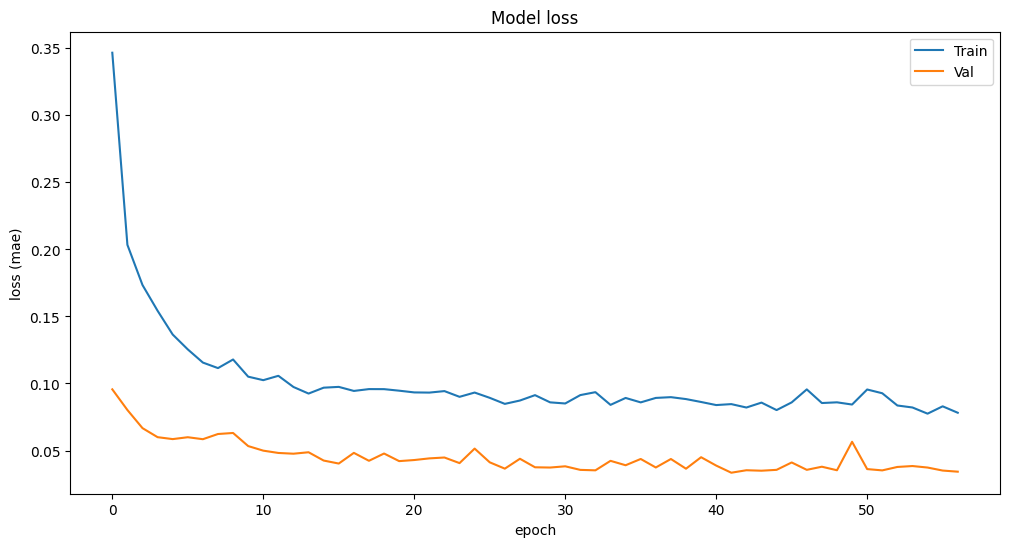

In [27]:
#Loss evens out relatively fast(Around 15th epoch), but there is continual gradual improvement
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mae)')
plt.legend(['Train', 'Val'], loc='upper right')

In [28]:
from sklearn.metrics import mean_squared_error

# Checking how much we are off on average
y_pred = hypermodel.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(y_pred[0:5])
print('mse:',mse)

9/9 [==============================] - 0s 626us/step
[[0.21991909]
 [0.23601818]
 [0.20515223]
 [0.22865164]
 [0.21668825]]
mse: 0.002492598459005373


In [29]:
predictions=hypermodel.predict(X_test)

9/9 [==============================] - 0s 626us/step


In [30]:
predictions = scaler.inverse_transform(predictions)
predictions.shape

(288, 1)

In [31]:
#The root mean squared error is very low
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(np.mean(y_test - predictions)**2).round(2)
rmse

1.92

In [32]:
preds_vs_actual = pd.DataFrame(data={'Predictions': predictions.flatten(), 'Actuals':y_test.flatten()})
preds_vs_actual

,Predictions,Actuals
0,291.704010,302.53
1,295.527924,283.86
2,288.196533,288.05
3,293.778198,287.87
4,290.936615,306.58
...,...,...
283,163.996033,158.66
284,158.871353,158.56
285,161.212021,156.97
286,156.978699,158.61


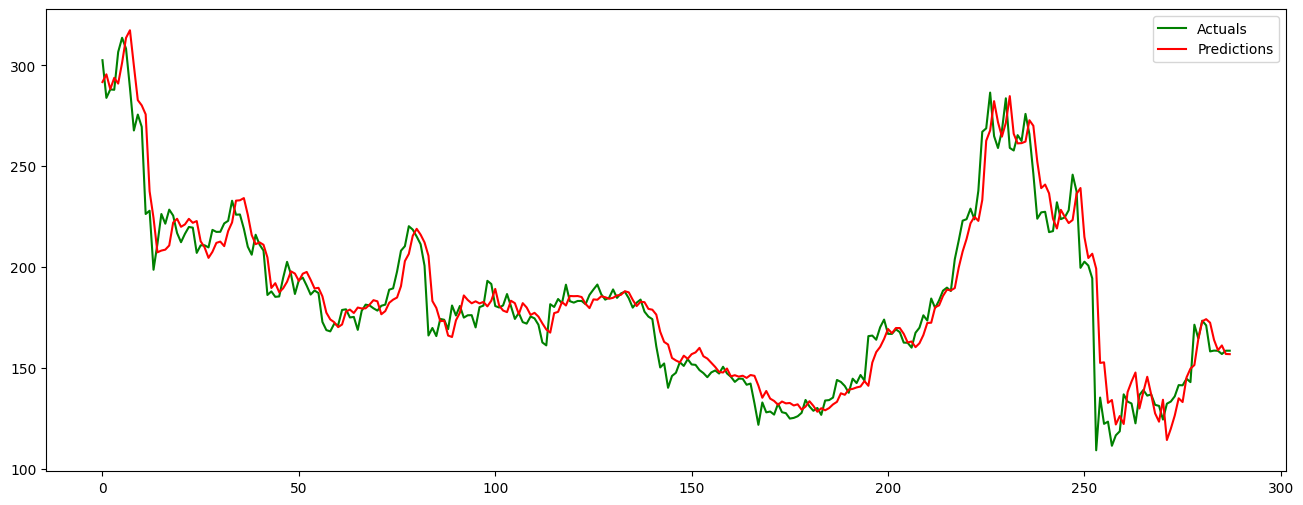

In [33]:
#Predictions fit well, the model seems to struggle a bit with rapid changes however, such as around 250.
plt.figure(figsize = (16,6))
plt.plot(preds_vs_actual['Actuals'], color='green')
plt.plot(preds_vs_actual['Predictions'], color='red')
plt.legend(['Actuals', 'Predictions'])

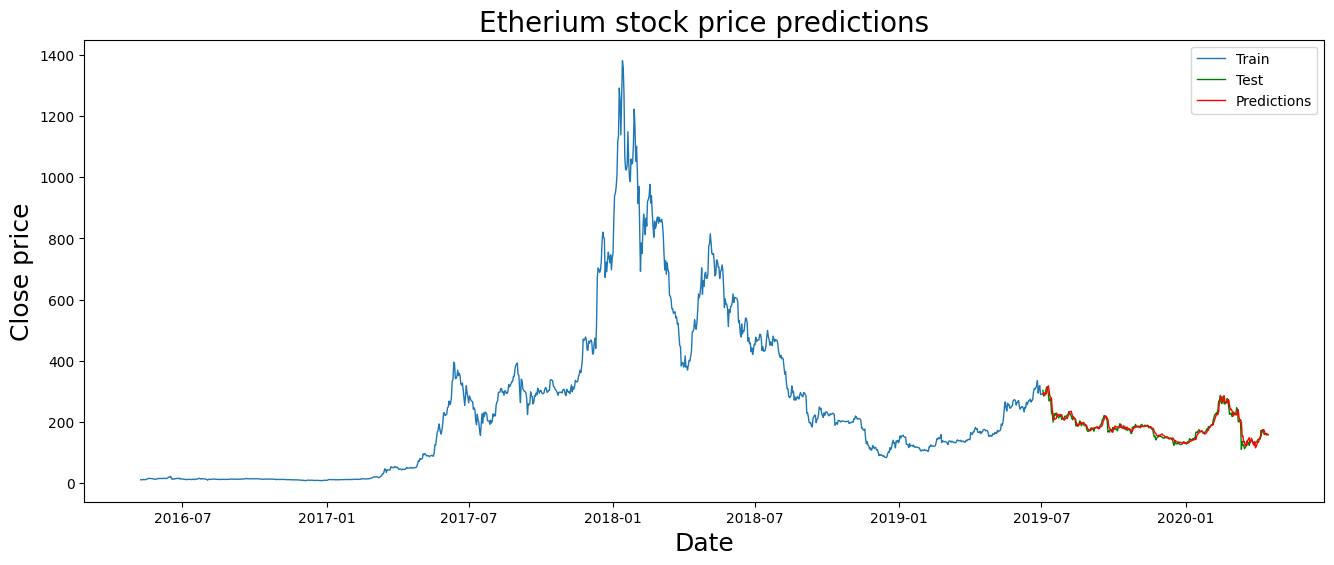

In [34]:
#Close fit over all, but is not extremely accurate. The slight dropout seemed to help with overfitting.
train = dataset.iloc[:train_size, 0:1]
test = dataset.iloc[train_size:,0:1]

test['predictions'] = predictions

plt.figure(figsize = (16,6))
plt.title('Etherium stock price predictions', fontsize = 20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price', fontsize = 18)
plt.plot(train[r'Close'], linewidth=1)
plt.plot(test[r'Close'], linewidth = 1, color='green')
plt.plot(test['predictions'], linewidth = 1, color='red')



plt.legend(['Train', 'Test', 'Predictions'])

# Conclusion

I tried quite a few things in this model. It seems that maxing the neurons was always the best fit for the first layer when time_steps is equal to 30. As this is a regression problem, adding more layers always seemed to over-complicate the model and give a much worse model, as crypto is less prone to repeating trends, and more-so fast paced changes.

One interesting thing I noticed was the difference between Normalizing the data and standardizing it. When normalizing, the model seems to struggle more with sudden changes in value, and seems to smooth itself out much more than it should for this type of problem. 

I experimented with the number of time_steps for each prediction. I tried 10,15,30, and 60. 30 seems to give the best overall results, and is the most consistent even in very turbulent zones

In the end, the model still seems to struggle with quick changes, as you can see after the large drop in the second to last graph. It does find overall trends pretty well, but often lags slightly behind actual values, making it questionably useful in the actual field. I think if I were to continue this model, I would adapt it to predict multiple days out, as it feels like it is just constantly lagging behind the actual data points. I think this is due to the fact thast crypto tends to move fairly minimally on a day by day basis, so the model assumes the next day will be very similar to the prievious.